# Tutorial: Multi scale cell-cell communication analysis using RGAST

In this tutorial, we applied RGAST onto the mouse hypothalamic preoptic MERFISH data (slice of Bregma +0.26) and conducted multi scale CCC analysis.

## Import library

In [2]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
import RGAST
import seaborn as sns
warnings.filterwarnings("ignore")

## read data

In [4]:
adata = sc.read_h5ad('../data/MERFISH/MERFISH_0.26.h5ad')
dir_output = '.'

In [5]:
adata.obs['cell_type'].value_counts()

cell_type
Inhibitory     1743
OD Mature      1031
Astrocyte       755
Endothelial     518
Excitatory      370
OD Immature     211
Microglia       133
Pericytes        70
Ependymal         1
Name: count, dtype: int64

In [6]:
# remove noisy cells and combine OD cells
adata = adata[adata.obs['cell_type'] != 'Ependymal']

OD_list = ['OD Mature','OD Immature']
adata.obs['cell_type'] = adata.obs['cell_type'].astype('str')
adata.obs['cell_type'][adata.obs['cell_type'].isin(OD_list)] = 'Oligodendrocyte'

In [7]:
#preprocess
sc.pp.normalize_total(adata, target_sum=1, exclude_highly_expressed=True)
sc.pp.scale(adata)
sc.pp.pca(adata, n_comps=100)

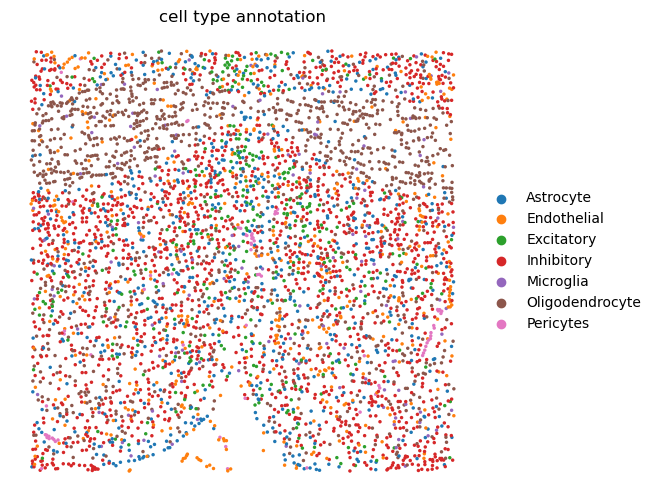

In [8]:
plt.rcParams["figure.figsize"] = (6,6)
sc.pl.embedding(adata, basis="spatial", color="cell_type", show=False)
plt.title("cell type annotation")
plt.axis('off')
plt.show()

## training

In [9]:
#Constructing the expression and spatial network
RGAST.utils.Cal_Spatial_Net(adata,rad_cutoff=50, model='Radius')
RGAST.utils.Cal_Expression_Net(adata,k_cutoff=3,dim_reduce='PCA')

------Calculating spatial graph...
Spatial graph contains 56608 edges, 4831 cells.
11.7177 neighbors per cell on average.
------Calculating Expression simalarity graph...
Expression graph contains 17474 edges, 4831 cells.
3.6171 neighbors per cell on average.


In [10]:
#Training model
train_RGAST = RGAST.Train_RGAST(adata,center_msg='out',dim_reduction='PCA',device_idx=2)
train_RGAST.train_RGAST(early_stopping=False,n_epochs=200,save_path=dir_output,att_drop = 0.0)

Size of Input:  torch.Size([4831, 100])


100%|██████████| 200/200 [00:09<00:00, 20.29it/s]


In [11]:
# inference
train_RGAST.load_model('model.pth')
_, _, att1, att2 = train_RGAST.process()
adata.uns['att1'] = (att1[0].to('cpu').numpy(),att1[1].to('cpu').numpy())
adata.uns['att2'] = (att2[0].to('cpu').numpy(),att2[1].to('cpu').numpy())

In [12]:
RGAST.cci.attention_to_interact(adata,cum_att_threshold=0.8)
adj = adata.obsp['interact_mat']

## Single-cell level CCC atlas

Here we see how Astrocyte interact with other cells by shrot-range interactions

In [14]:
# select interested cell type for visulization
highlight_ct = 'Astrocyte'
ct_adj = RGAST.cci.celltype_adj(highlight_ct, adj, adata.obs['cell_type'])

In [15]:
adj_short, adj_long = RGAST.cci.classify_range2(adata.obsm['spatial'], ct_adj, 70)

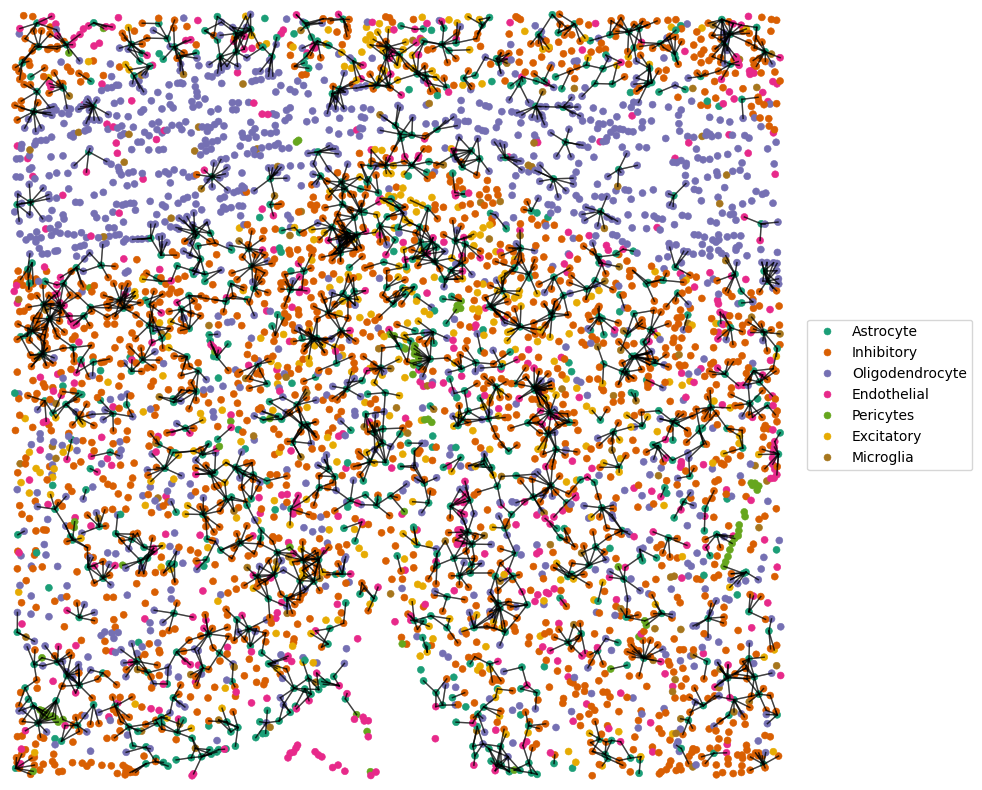

In [19]:
# set colors
my_cmap = {'Astrocyte': '#1b9e77',
 'Inhibitory': '#d95f02',
 'Oligodendrocyte': '#7570b3',
 'Endothelial': '#e7298a',
 'Pericytes': '#66a61e',
 'Excitatory': '#e6ab02',
 'Microglia': '#a6761d'}

plt.rcParams["figure.figsize"] = (10,10)
RGAST.cci.plot_cell_adj(adata.obsm['spatial'],adata.obs['cell_type'].astype(str),adj_short,cmap=my_cmap)

## Niche-level CCC analysis

<Axes: >

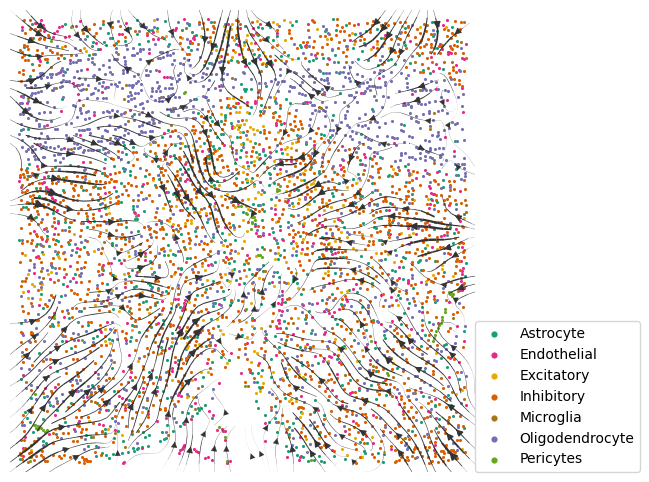

In [21]:
RGAST.cci.cal_communication_direction(adata)

plt.rcParams["figure.figsize"] = (6,6)
RGAST.cci.plot_cell_communication(adata,plot_method='stream',background='cluster',clustering='cell_type',cluster_cmap=my_cmap,ndsize=5,background_legend=True,stream_density=2)

## Cell-type level CCC analysis

In [22]:
connectivity = RGAST.cci.calculate_connection_matrix(adata.obsp['interact_mat'],adata.obs['cell_type'])
counts_table = adata.obs['cell_type'].value_counts()

CCC_score = connectivity.copy()
for i in connectivity.index:
    for j in connectivity.columns:
        CCC_score.loc[i,j] = connectivity.loc[i,j]/(counts_table[i]*counts_table[j])

plot_mat_np = CCC_score.to_numpy()
plot_mat_np[np.triu_indices(CCC_score.shape[0],k=0)] = None
plot_mat = pd.DataFrame(plot_mat_np,index=CCC_score.index,columns=CCC_score.columns)
plot_mat = plot_mat.iloc[1:,:-1]

<Axes: >

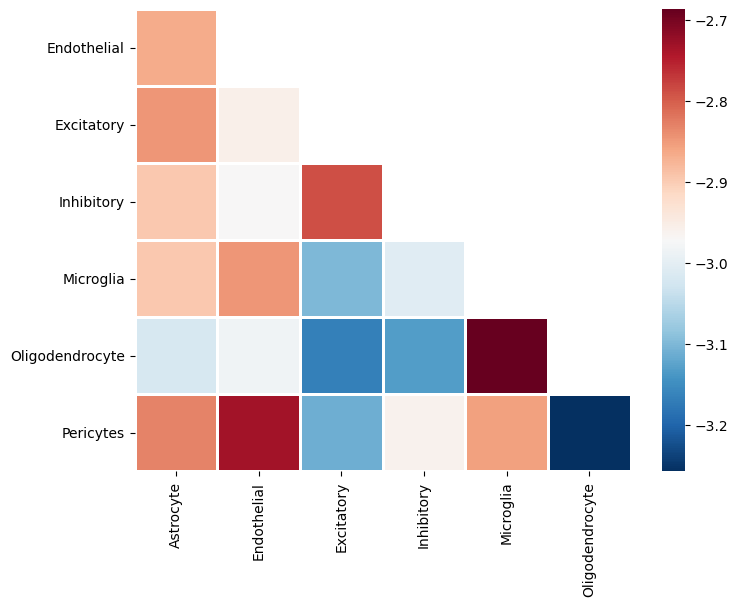

In [23]:
plt.rcParams["figure.figsize"] = (8,6)
sns.heatmap(np.log10(plot_mat), cmap='RdBu_r', linewidths=2)